# Group Classifier Validation

Load a trained group classifier model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create evaluation plots (confusion matrices, ROC curves, precision-recall, loss curves)


In [1]:
import json
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Optional

from pioneerml.zenml import utils as zenml_utils
from pioneerml.models.classifiers.group_classifier import GroupClassifier
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES
from pioneerml.data.loaders import load_preprocessed_time_groups
from pioneerml.training.datamodules import GroupClassificationDataModule
from pioneerml.training.lightning import GraphLightningModule
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

PROJECT_ROOT = zenml_utils.find_project_root()
checkpoints_dir = Path(PROJECT_ROOT) / "artifacts" / "checkpoints" / "group_classifier"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Checkpoints directory: {checkpoints_dir}")


Project root: /home/jack/python_projects/pioneerML
Checkpoints directory: /home/jack/python_projects/pioneerML/artifacts/checkpoints/group_classifier


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# Find all checkpoint files
checkpoint_files = sorted(checkpoints_dir.glob("group_classifier_*.pt"), reverse=True)
metadata_files = sorted(checkpoints_dir.glob("group_classifier_*_metadata.json"), reverse=True)

print(f"Found {len(checkpoint_files)} checkpoint(s):")
for i, ckpt in enumerate(checkpoint_files, 1):
    print(f"  {i}. {ckpt.name}")
    # Find corresponding metadata
    timestamp = ckpt.stem.replace("group_classifier_", "")
    metadata_file = checkpoints_dir / f"group_classifier_{timestamp}_metadata.json"
    if metadata_file.exists():
        with open(metadata_file) as f:
            meta = json.load(f)
        print(f"     Timestamp: {meta.get('timestamp', 'unknown')}")
        print(f"     Run: {meta.get('run_name', 'unknown')}")
        if 'model_architecture' in meta:
            arch = meta['model_architecture']
            print(f"     Architecture: hidden={arch.get('hidden')}, num_blocks={arch.get('num_blocks')}, dropout={arch.get('dropout')}")

# Select the most recent checkpoint by default
selected_checkpoint = checkpoint_files[0] if checkpoint_files else None
selected_metadata = None
if selected_checkpoint:
    timestamp = selected_checkpoint.stem.replace("group_classifier_", "")
    metadata_file = checkpoints_dir / f"group_classifier_{timestamp}_metadata.json"
    if metadata_file.exists():
        with open(metadata_file) as f:
            selected_metadata = json.load(f)
        print(f"\nSelected checkpoint: {selected_checkpoint.name}")
        print(f"Metadata loaded from: {metadata_file.name}")
else:
    print("\nNo checkpoints found! Train a model first.")


Found 1 checkpoint(s):
  1. group_classifier_20251203_012349.pt
     Timestamp: 20251203_012349
     Run: group_classification_optuna_pipeline-2025_12_03-06_19_29_909700
     Architecture: hidden=256, num_blocks=4, dropout=0.21067719814450897

Selected checkpoint: group_classifier_20251203_012349.pt
Metadata loaded from: group_classifier_20251203_012349_metadata.json


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
if selected_checkpoint is None or selected_metadata is None:
    raise ValueError("No checkpoint or metadata found. Please train a model first.")

# Extract model architecture from metadata
arch = selected_metadata.get("model_architecture", {})
best_params = selected_metadata.get("best_hyperparameters", {})

# Use architecture params from metadata, fallback to best_params
hidden = arch.get("hidden") or best_params.get("hidden", 192)
num_blocks = arch.get("num_blocks") or best_params.get("num_blocks", 3)
dropout = arch.get("dropout") or best_params.get("dropout", 0.1)
num_classes = arch.get("num_classes") or NUM_GROUP_CLASSES

print(f"Reconstructing model with:")
print(f"  hidden: {hidden}")
print(f"  num_blocks: {num_blocks}")
print(f"  dropout: {dropout}")
print(f"  num_classes: {num_classes}")

# Create model with same architecture
model = GroupClassifier(
    hidden=int(hidden),
    num_blocks=int(num_blocks),
    dropout=float(dropout),
    num_classes=int(num_classes),
)

# Load state dict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(selected_checkpoint, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"\nModel loaded successfully on {device}")
print(f"  Checkpoint: {selected_checkpoint.name}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")


Reconstructing model with:
  hidden: 256
  num_blocks: 4
  dropout: 0.21067719814450897
  num_classes: 3

Model loaded successfully on cuda
  Checkpoint: group_classifier_20251203_012349.pt
  Parameters: 4,219,396


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).


In [4]:
# Load validation data
# Use the same file pattern as training, or specify a different one
file_pattern = str(Path(PROJECT_ROOT) / "data" / "mainTimeGroups_*.npy")

# For validation, we might want to use fewer files or a different subset
# Adjust these parameters as needed
validation_groups = load_preprocessed_time_groups(
    file_pattern,
    max_files=2,  # Use fewer files for faster validation
    limit_groups=50000,  # Limit total groups for faster validation
    min_hits=2,
    min_hits_per_label=2,
    verbose=True,
)

print(f"\nLoaded {len(validation_groups)} groups for validation")

# Create datamodule
datamodule = GroupClassificationDataModule(
    records=validation_groups,
    num_classes=NUM_GROUP_CLASSES,
    batch_size=128,
    num_workers=0,  # Set to 0 for validation to avoid multiprocessing issues
    val_split=0.2,  # Use 20% for validation
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")


Limiting to 2 files (from 11 total files found, max_files=2)
Loaded 50000 groups from 2 files (pion: 17032, muon: 17015, mip: 17027)



Loaded 50000 groups for validation
Validation dataset size: 10000


## Generate Predictions

Run inference on the validation dataset.


In [5]:
from torch_geometric.loader import DataLoader

# Create dataloader
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

# Generate predictions
all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)
        all_predictions.append(preds.cpu())
        all_targets.append(batch.y.cpu())

# Concatenate all predictions and targets
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Generated predictions:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Targets shape: {targets.shape}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")


Generated predictions:
  Predictions shape: torch.Size([10000, 3])
  Targets shape: torch.Size([30000])
  Predictions range: [-498.6686, 270.9743]


## Generate Validation Plots

Create comprehensive evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "group_classifier"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = selected_metadata.get("timestamp", datetime.now().strftime("%Y%m%d_%H%M%S"))
plot_prefix = f"group_classifier_{timestamp_str}"

# Get class names from metadata or use defaults
dataset_info = selected_metadata.get("dataset_info", {})
class_names = dataset_info.get("class_names", list(CLASS_NAMES.values()))

print(f"Generating validation plots in: {plots_dir}")
print(f"Class names: {class_names}")


Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/group_classifier
Class names: ['pion', 'muon', 'mip']



1. Generating confusion matrix...
/home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:51: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-scores))



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # 1. Confusion Matrix                                                                       │
│    2 print("\n1. Generating confusion matrix...")                                                │
│    3 confusion_path = plots_dir / f"{plot_prefix}_confusion_matrix.png"                          │
│ ❱  4 plot_multilabel_confusion_matrix(                                                           │
│    5 │   predictions=predictions,                                                                │
│    6 │   targets=targets,                                                                        │
│    7 │   class_names=class_names,                                                                │
│                                                                                                  │
│ /home/jack/python_projects/pioneerML/src/pioneerml/evaluation/plots.py:217 in                    │
│ plot_multilabel_confusion_matrix                                                                 │
│                                                                                                  │
│   214 │   │   if idx >= num_classes:                                                             │
│   215 │   │   │   ax.axis("off")                                                                 │
│   216 │   │   │   continue                                                                       │
│ ❱ 217 │   │   cm = confusion_matrix(                                                             │
│   218 │   │   │   y_true_binary[:, idx], y_pred[:, idx], labels=[0, 1], normalize="all" if nor   │
│   219 │   │   )                                                                                  │
│   220 │   │   if normalize and cm.sum() > 0:                                                     │
│                                                                                                  │
│ /home/jack/miniconda3/envs/pioneerml/lib/python3.11/site-packages/sklearn/utils/_param_validatio │
│ n.py:218 in wrapper                                                                              │
│                                                                                                  │
│   215 │   │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation            │
│   216 │   │   │   │   │   )                                                                      │
│   217 │   │   │   │   ):                                                                         │
│ ❱ 218 │   │   │   │   │   return func(*args, **kwargs)                                           │
│   219 │   │   │   except InvalidParameterError as e:                                             │
│   220 │   │   │   │   # When the function is just a wrapper around an estimator, we allow        │
│   221 │   │   │   │   # the function to delegate validation to the estimator, but we replace     │
│                                                                                                  │
│ /home/jack/miniconda3/envs/pioneerml/lib/python3.11/site-packages/sklearn/metrics/_classificatio │
│ n.py:467 in confusion_matrix                                                                     │
│                                                                                                  │
│    464 │   (0, 2, 1, 1)                                                                          │
│    465 │   """                                                                                   │
│    466 │   y_true, y_pred = attach_unique(y_true, y_pred)                                        │
│ ❱  467 │   y_type, y_true, y_pred = _check_targets(y_true, 

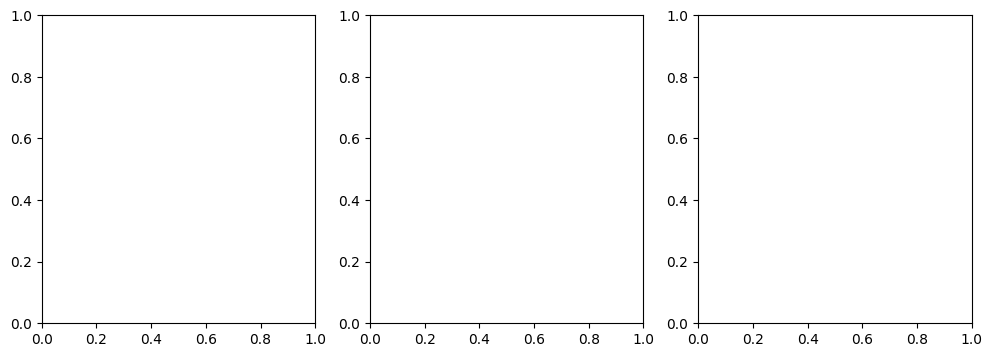

In [7]:
# 1. Confusion Matrix
print("\n1. Generating confusion matrix...")
confusion_path = plots_dir / f"{plot_prefix}_confusion_matrix.png"
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)


In [ ]:
# 2. ROC Curves
print("\n2. Generating ROC curves...")
roc_path = plots_dir / f"{plot_prefix}_roc_curves.png"
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)


In [ ]:
# 3. Precision-Recall Curves
print("\n3. Generating precision-recall curves...")
pr_path = plots_dir / f"{plot_prefix}_precision_recall.png"
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    show=True,
)
